In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier


In [3]:
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

In [5]:
y = y.values.flatten()

In [6]:
inner_cv = StratifiedKFold(n_splits = 3, shuffle=True,random_state=42)
outer_cv = StratifiedKFold(n_splits = 10, shuffle=True,random_state=42)

Make Grid Search for Random Forest models.

In [7]:
hyperparams_RF = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [None, 5, 10, 20],
    'n_estimators' : [20,50,100]
}

grid_RF = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=hyperparams_RF,
    scoring='roc_auc',  # Beispiel für mehrklassige AUC
    cv=inner_cv,                     # innere CV (z.B. 3-fach)
)
scores_RF = cross_validate(grid_RF, X=X, y=y, cv=outer_cv, scoring=["roc_auc", "accuracy"], return_train_score=True)

In [8]:
df = pd.DataFrame(scores_RF)

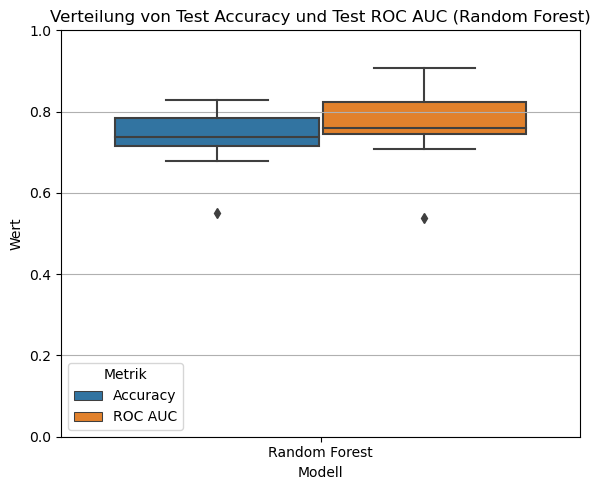

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Beispiel: DataFrame df aus cross_validate
# df = pd.DataFrame(scores_RF)

# Daten für Boxplot vorbereiten
plot_data = pd.DataFrame({
    'Metrik': ['Accuracy'] * len(df) + ['ROC AUC'] * len(df),
    'Wert': list(df['test_accuracy']) + list(df['test_roc_auc']),
    'Modell': ['Random Forest'] * (2 * len(df))  # Dummy-Spalte für konsistente X-Achse
})

# Plot
plt.figure(figsize=(6, 5))
sns.boxplot(data=plot_data, x='Modell', y='Wert', hue='Metrik')

plt.title('Verteilung von Test Accuracy und Test ROC AUC (Random Forest)')
plt.ylim(0.0, 1.0)
plt.grid(axis='y')
plt.legend(title='Metrik', loc='lower left')
plt.tight_layout()
plt.show()


In [10]:
model_evaluation = pd.DataFrame({"Fold": range(1, 11)})
model_evaluation['Modell'] = ['Random Forest'] * 10
model_evaluation['ROC AUC'] = df['test_roc_auc']
model_evaluation['Accuracy'] = df['test_accuracy']
model_evaluation["runtime"] = df["fit_time"]/24
model_evaluation

,Fold,Modell,ROC AUC,Accuracy,runtime
0,1,Random Forest,0.800000,0.827586,0.697904
1,2,Random Forest,0.747222,0.758621,0.645571
2,3,Random Forest,0.866667,0.793103,0.745575
3,4,Random Forest,0.708333,0.551724,0.863973
4,5,Random Forest,0.772222,0.758621,0.652087
5,6,Random Forest,0.906433,0.714286,0.667390
6,7,Random Forest,0.830409,0.821429,0.556964
7,8,Random Forest,0.538012,0.678571,0.559423
8,9,Random Forest,0.743750,0.714286,0.551591
9,10,Random Forest,0.743750,0.714286,0.510259


In [11]:
model_evaluation.to_pickle('model_evaluation/Random_Forest.pkl')

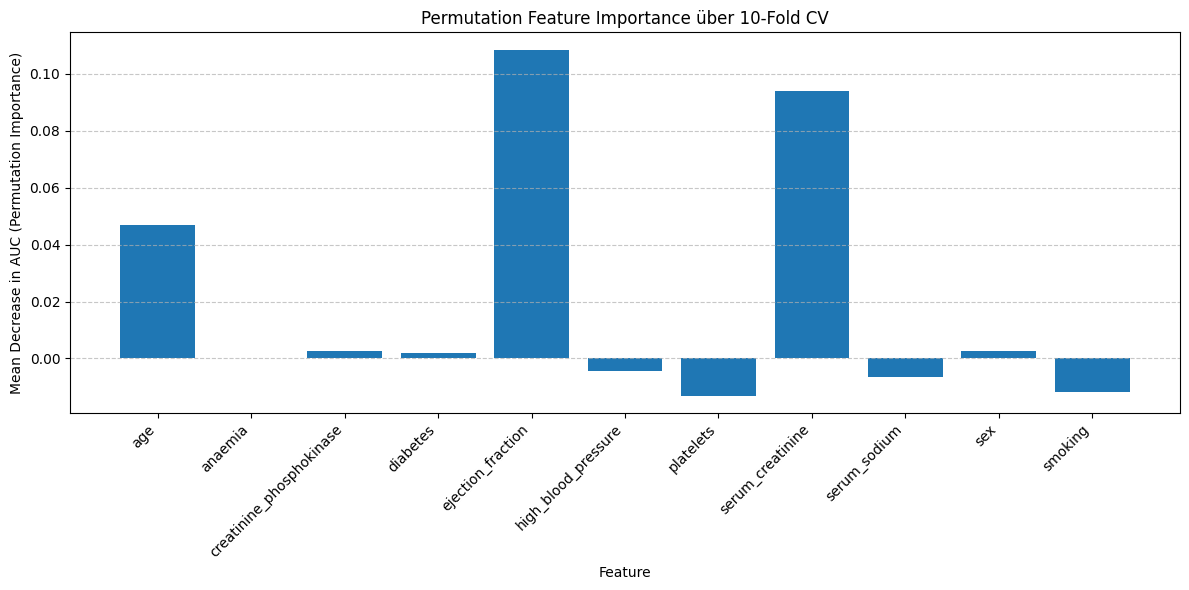

                     Feature  MeanImportance  StdImportance
0                        age        0.046983       0.050011
1                    anaemia        0.000020       0.017797
2   creatinine_phosphokinase        0.002741       0.039029
3                   diabetes        0.001996       0.013555
4          ejection_fraction        0.108527       0.078664
5        high_blood_pressure       -0.004521       0.012215
6                  platelets       -0.013017       0.037620
7           serum_creatinine        0.093991       0.103054
8               serum_sodium       -0.006489       0.022750
9                        sex        0.002754       0.017655
10                   smoking       -0.011880       0.023707


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score
from collections import defaultdict

# Feature-Namen aus DataFrame
feature_names = list(X.columns)

# Konvertiere X und y in NumPy-Arrays
X = X.to_numpy()
y_zero_one = y['death_event'].to_numpy()

def model_fitting(X, y, feature_names):
    hyperparams_RF = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 20],
        'n_estimators': [20, 50, 100]
    }
    
    outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    outer_scores = []
    perm_importances = defaultdict(list)  # feature index -> list of AUC drops
    
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        grid_RF = GridSearchCV(
            estimator=RandomForestClassifier(random_state=42),
            param_grid=hyperparams_RF,
            scoring='roc_auc',
            cv=inner_cv,
            n_jobs=-1
        )
        grid_RF.fit(X_train, y_train)
        best_model = grid_RF.best_estimator_
        
        # Baseline AUC auf Testdaten (nutze predict_proba)
        y_score_test = best_model.predict_proba(X_test)[:, 1]  # Nur Klasse 1
        auc_baseline = roc_auc_score(y_test, y_score_test)
        outer_scores.append(auc_baseline)
        
        # Permutation Feature Importance (AUC-Drop)
        for i in range(X_test.shape[1]):
            X_test_permuted = X_test.copy()
            X_test_permuted[:, i] = np.random.permutation(X_test_permuted[:, i])
            y_score_perm = best_model.predict_proba(X_test_permuted)[:, 1]
            auc_perm = roc_auc_score(y_test, y_score_perm)
            perm_importances[i].append(auc_baseline - auc_perm)
    
    # Durchschnittliche Importance pro Feature über alle Folds
    mean_importances = np.array([np.mean(perm_importances[i]) for i in range(X.shape[1])])
    std_importances = np.array([np.std(perm_importances[i]) for i in range(X.shape[1])])
    
    # DataFrame für Übersicht
    df_importances = pd.DataFrame({
        'Feature': feature_names,
        'MeanImportance': mean_importances,
        'StdImportance': std_importances
    })#.sort_values(by='MeanImportance', ascending=False).reset_index(drop=True)
    
    # Visualisierung
    plt.figure(figsize=(12, 6))
    plt.bar(df_importances['Feature'], df_importances['MeanImportance'])
    plt.xlabel('Feature')
    plt.ylabel('Mean Decrease in AUC (Permutation Importance)')
    plt.title('Permutation Feature Importance über 10-Fold CV')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return outer_scores, df_importances

# Beispiel-Aufruf
outer_scores, df_importances = model_fitting(X, y_zero_one, feature_names)
print(df_importances)


In [19]:
df_feature_selection = pd.DataFrame({
    'Feature': feauture_names,
    'average decrease in AUC': df_importances["MeanImportance"]
})
print(df_feature_selection)
df_feature_selection.to_pickle('feature_importance/RF.pkl')

                     Feature  average decrease in AUC
0                        age                 0.046983
1                    anaemia                 0.000020
2   creatinine_phosphokinase                 0.002741
3                   diabetes                 0.001996
4          ejection_fraction                 0.108527
5        high_blood_pressure                -0.004521
6                  platelets                -0.013017
7           serum_creatinine                 0.093991
8               serum_sodium                -0.006489
9                        sex                 0.002754
10                   smoking                -0.011880
